# Fragurancy error rate

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import glob
from pathlib import Path
run_names = {
    "aviti_ngi": "AVITI CB FS",
    "aviti_hq": "AVITI CB",
    "xplus_sns": "NovaSeqX+",
}

custom_params = {"axes.spines.right": False, "axes.spines.top": False}

sns.set_theme(
    context="notebook",
    style="ticks", 
    palette="colorblind",
    font_scale=1.1,
    rc=custom_params
)

basedir = Path("../analysis/error_rate/fragurancy")

# For SVG output
plt.rcParams['svg.fonttype'] = 'none'
figdir = Path("../figures/svg")

In [3]:
%load_ext watermark

In [4]:
%watermark

Last updated: 2025-02-21T13:40:43.888548+01:00

Python implementation: CPython
Python version       : 3.12.6
IPython version      : 8.28.0

Compiler    : Clang 17.0.6 
OS          : Darwin
Release     : 24.2.0
Machine     : x86_64
Processor   : i386
CPU cores   : 11
Architecture: 64bit



In [5]:
%watermark -iv

seaborn   : 0.13.2
pandas    : 2.2.3
matplotlib: 3.9.2
numpy     : 2.1.1



## Error rate

In [4]:
runs=["aviti_hq", "aviti_ngi", "xplus_sns"]
cells = ["OPM2", "KMS12BM", "MM1S", "REH"]

data = []
for run in runs:
    for cell in cells:
        file = basedir / f"{run}_{cell}{cell}_{cell}-counts.txt"
        df = pd.read_csv(file, sep="\t")
        df["run"] = run
        df["Cell line"] = cell

        data.append(df)


data = pd.concat(data)
data["Data source"] = data["run"].replace(run_names)
data = data[data["total_count"] > 0]
data.head()

,read12,FR,bq_bin,read_pos,context,hp_dist,total_count,error_count,err_rate_lo,err_rate_hi,run,Cell line,Data source
127,r1,f,0-5,0,CA,NaN,1,0,0.000000,0.832506,aviti_hq,OPM2,AVITI CB
159,r1,f,0-5,0,CG,NaN,1,1,0.167494,1.039049,aviti_hq,OPM2,AVITI CB
191,r1,f,0-5,0,CT,NaN,1,0,0.000000,0.832506,aviti_hq,OPM2,AVITI CB
223,r1,f,05-19,0,AC,NaN,1,0,0.000000,0.832506,aviti_hq,OPM2,AVITI CB
255,r1,f,05-19,0,AG,NaN,1,0,0.000000,0.832506,aviti_hq,OPM2,AVITI CB


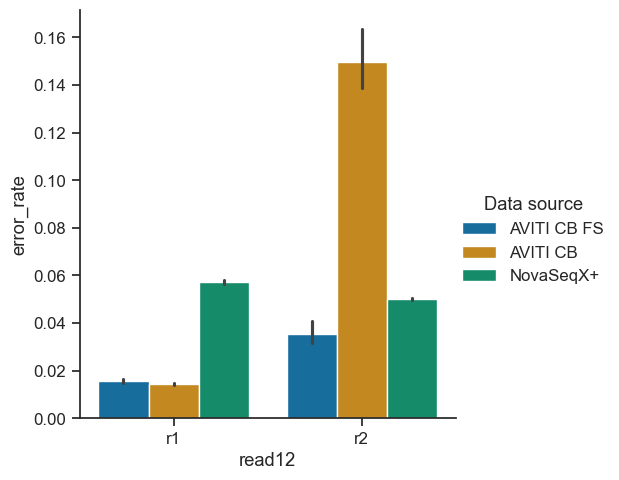

In [5]:
d = data.groupby(["Data source", "Cell line", "read12"]).agg({"total_count": "sum", "error_count": "sum"}).reset_index()
d["error_rate"] = 100 * d["error_count"] / d["total_count"]
sns.catplot(d, kind="bar", hue="Data source", y="error_rate", x="read12",
            hue_order=run_names.values())

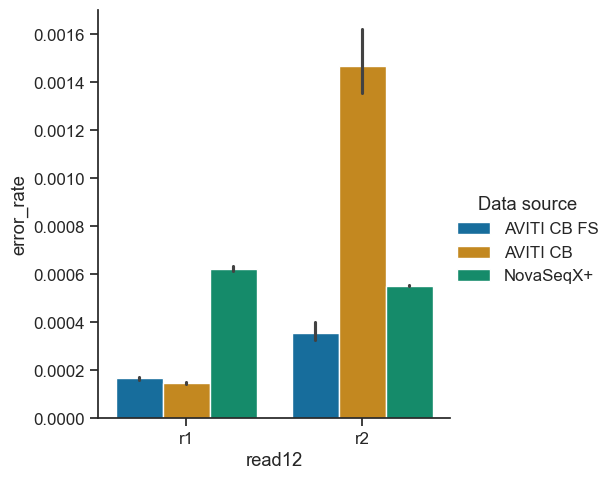

In [6]:
d = data[data["read_pos"] > 100]
d = d.groupby(["Data source", "Cell line", "read12"]).agg({"total_count": "sum", "error_count": "sum"}).reset_index()
d["error_rate"] = d["error_count"] / d["total_count"]
sns.catplot(d, kind="bar", hue="Data source", y="error_rate", x="read12",
            hue_order=run_names.values())

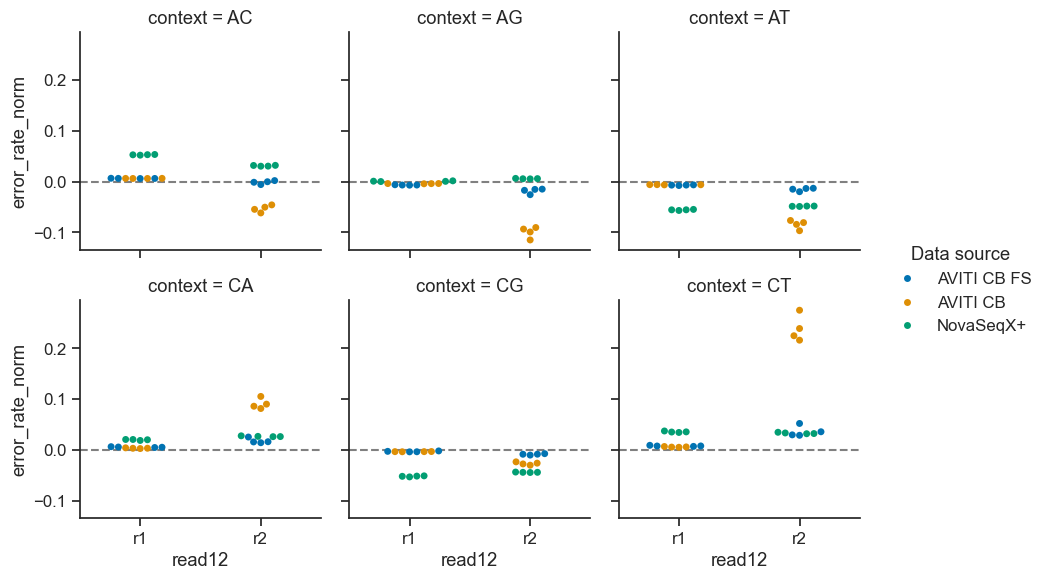

In [7]:
def norm(x):
    error_rates = x["error_count"] / x["total_count"]
    total_rate = x["error_count"].sum() / x["total_count"].sum()
    print(error_rates)
    return pd.Series(error_rates - total_rate)
    

d = data.groupby(["Data source", "Cell line", "context", "read12"]).agg({"total_count": "sum", "error_count": "sum"}).reset_index()
d["error_rate"] = 100 * d["error_count"] / d["total_count"]

d["error_count_total"] = d.groupby(
    ["Data source", "Cell line", "read12"]
    )["error_count"].transform(lambda x: [x.sum()]*len(x))
d["total_count_total"] = d.groupby(
    ["Data source", "Cell line", "read12"]
    )["total_count"].transform(lambda x: [x.sum()]*len(x))
d["error_rate_total"] = 100 * d["error_count_total"] / d["total_count_total"]

d["error_rate_norm"] = d["error_rate"] - d["error_rate_total"]
g = sns.catplot(d, kind="swarm", x="read12", y="error_rate_norm", hue="Data source", 
            hue_order=run_names.values(), col="context", col_wrap=3, height=3)
g.refline(y=0)

### Redirect reads to match orientations

In [8]:
data_inv = data.copy()

# Flip reverse oriented reads to match f positions
data_inv.loc[data_inv.FR == "r", "read_pos"] = np.abs(data_inv.loc[data_inv.FR == "r", "read_pos"] - 150)
data_inv["Cycle"] = data_inv["read_pos"]
data_inv.loc[data_inv.read12 == "r2", "Cycle"] = data_inv.loc[data_inv.read12 == "r2", "Cycle"] + 150
data_inv

,read12,FR,bq_bin,read_pos,context,hp_dist,total_count,error_count,err_rate_lo,err_rate_hi,run,Cell line,Data source,Cycle
127,r1,f,0-5,0,CA,NaN,1,0,0.000000,0.832506,aviti_hq,OPM2,AVITI CB,0
159,r1,f,0-5,0,CG,NaN,1,1,0.167494,1.039049,aviti_hq,OPM2,AVITI CB,0
191,r1,f,0-5,0,CT,NaN,1,0,0.000000,0.832506,aviti_hq,OPM2,AVITI CB,0
223,r1,f,05-19,0,AC,NaN,1,0,0.000000,0.832506,aviti_hq,OPM2,AVITI CB,0
255,r1,f,05-19,0,AG,NaN,1,0,0.000000,0.832506,aviti_hq,OPM2,AVITI CB,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578559,r2,r,37-59,1,AG,NaN,5210,0,0.000000,0.000889,xplus_sns,REH,NovaSeqX+,151
578591,r2,r,37-59,1,AT,NaN,5210,0,0.000000,0.000889,xplus_sns,REH,NovaSeqX+,151
578623,r2,r,37-59,1,CA,NaN,3284,1,0.000000,0.001907,xplus_sns,REH,NovaSeqX+,151
578655,r2,r,37-59,1,CG,NaN,3284,1,0.000000,0.001907,xplus_sns,REH,NovaSeqX+,151


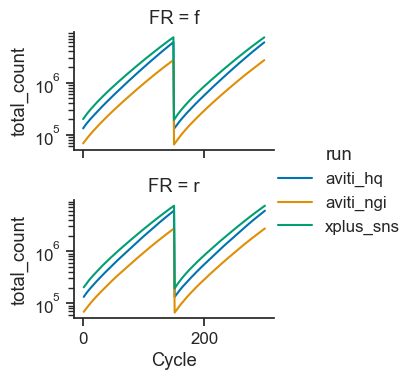

In [9]:
d = data_inv.groupby(["run", "FR", "Cycle"]).agg({"total_count": "sum", "error_count": "sum"}).reset_index()
g = sns.relplot(d, x="Cycle", y="total_count", hue="run", row="FR", kind="line", height=2,aspect=1.5)
g.set(yscale="log")

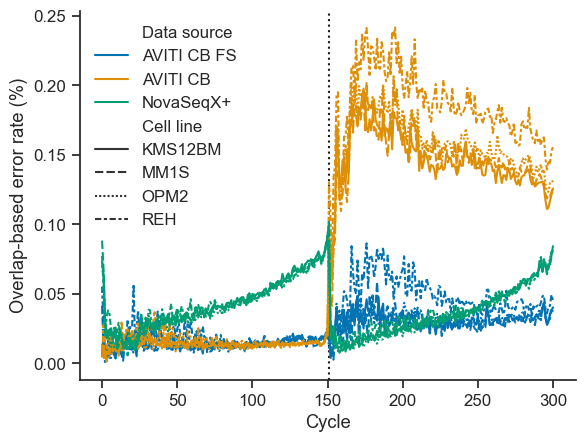

In [10]:
d = data_inv.groupby(["Data source", "Cell line", "Cycle"]).agg({"total_count": "sum", "error_count": "sum"}).reset_index()
d["Mismatches per base"] = 100  * d["error_count"] / d["total_count"]
#d["Mismatches per base smooth"] = d.groupby(["Data source", "read12", "cell"])["Mismatches per base"].transform(lambda x: x.rolling(5, center=True).mean())
ax = sns.lineplot(d, x="Cycle", y="Mismatches per base", hue="Data source", 
                hue_order=run_names.values(), 
                style="Cell line")
#g.map(sns.lineplot, "read_pos", "Mismatches per base", "Data source", alpha=0.2, hue_order=run_names.values())
ax.set_xlabel("Cycle")
ax.set_ylabel("Overlap-based error rate (%)")
ax.legend(frameon=False, framealpha=0)
ax.axvline(151, color="k", ls=":", zorder=-1)

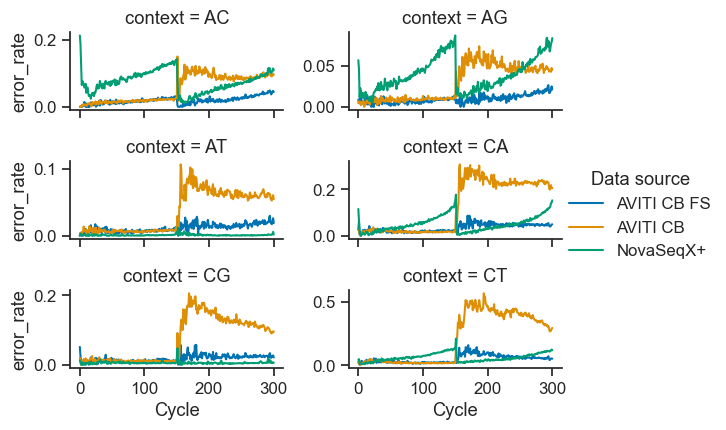

In [79]:

d = data_inv.groupby(["Data source", "Cycle", "context"]).agg({"total_count": "sum", "error_count": "sum"}).reset_index()
d["error_rate"] = 100 * d["error_count"] / d["total_count"]
#d["error_rate_smooth"] = d.groupby(["Data source", "read12", "context"])["error_rate"].transform(lambda x: x.rolling(5, center=True).mean())

g = sns.relplot(d, x="Cycle", y="error_rate", col="context", col_wrap=2,
                hue="Data source", height=1.5,  aspect=2, kind="line", 
                facet_kws=dict(sharey=False), hue_order=run_names.values())
#g.map(sns.lineplot, "read_pos", "error_rate", "Data source", alpha=0.2)